https://www.cl.cam.ac.uk/teaching/2021/LE49/probnn/3-3.pdf

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
from sklearn.metrics import precision_score, recall_score, roc_curve
from sklearn.linear_model import LogisticRegression

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

/Users/ee24pl/opt/miniconda3/envs/min_prec/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# models

In [5]:
class LogReg2(nn.Module):
    """Normal logistic regression with BCE loss"""
    def __init__(self, nfeat):
        super().__init__()
        
        self.nfeat = nfeat
        self.beta = nn.Parameter(torch.zeros([nfeat+1], dtype=torch.float))
        
    def forward(self, x, y):
        x = np.column_stack((x, np.ones([x.shape[0]])))
        x = torch.from_numpy(x).float()
        y = torch.from_numpy(y)
        
        
        self.f = x @ self.beta
        
        stablelogisticloss = nn.BCEWithLogitsLoss()
        return stablelogisticloss(self.f, y.float())
    
    def predict_proba(self, xtest):
        if len(xtest.shape) == 1:
            xtest = xtest.reshape([1, self.nfeat])
        
        xtest = np.column_stack((xtest, np.ones([xtest.shape[0]])))
        xtest = torch.from_numpy(xtest).float()
        
        f = xtest @ self.beta
        return torch.sigmoid(f).detach().numpy().flatten()
    
    def fit(self, x, y, optimizer, n_batches=10_000):
        
        for _ in range(n_batches):
            optimizer.zero_grad()
            loss = self.forward(x, y)
            loss.backward()
            optimizer.step()

In [22]:
class LogReg_weights(nn.Module):
    """Normal logistic regression with BCE loss"""
    def __init__(self, nfeat, weight):
        super().__init__()
        
        self.nfeat = nfeat
        self.beta = nn.Parameter(torch.zeros([nfeat+1], dtype=torch.float))
        self.weight = weight * torch.ones([10000])
        
    def forward(self, x, y):
        x = np.column_stack((x, np.ones([x.shape[0]])))
        x = torch.from_numpy(x).float()
        y = torch.from_numpy(y)
        
        
        self.f = x @ self.beta
        
        stablelogisticloss = nn.BCEWithLogitsLoss(pos_weight=self.weight)
        return stablelogisticloss(self.f, y.float())
    
    def predict_proba(self, xtest):
        if len(xtest.shape) == 1:
            xtest = xtest.reshape([1, self.nfeat])
        
        xtest = np.column_stack((xtest, np.ones([xtest.shape[0]])))
        xtest = torch.from_numpy(xtest).float()
        
        f = xtest @ self.beta
        return torch.sigmoid(f).detach().numpy().flatten()
    
    def fit(self, x, y, optimizer, n_batches=10_000):
        
        for _ in range(n_batches):
            optimizer.zero_grad()
            loss = self(x, y)
            loss.backward()
            optimizer.step()

In [7]:
# class LogRegMaxRecall2(nn.Module):
#     def __init__(self, x, y, min_prec=0.8, lam=1e4):
#         super().__init__()

#         self.min_prec = min_prec
#         sklearnlogreg = LogisticRegression()
#         sklearnlogreg = sklearnlogreg.fit(x,y)
#         sklearnbetas = np.concatenate([sklearnlogreg.coef_.flatten(), sklearnlogreg.intercept_])
        
#         self.beta = nn.Parameter(torch.from_numpy(sklearnbetas).float())

#         #Page 6 of paper, second-to-last paragraph
#         self.lmbda = lam
                
#     def forward(self, x, y):
#         x = np.column_stack((x, np.ones([x.shape[0]])))
#         x = torch.from_numpy(x).float()
#         y = torch.from_numpy(y)#.type(torch.LongTensor)
        
#         #Paragraph below eqn 14 in paper
#         self.gamma = torch.tensor(7.)
#         self.delta = torch.tensor(0.035)
        
#         #self.f = self.beta0 + self.beta1*x
#         self.f = x @ self.beta
        
#         #Eqn 11 in paper
#         #tpc = torch.sum(torch.where(y==1., self.gamma*self.delta + torch.where(self.f>0., torch.tensor(1.), torch.tensor(0.)), torch.tensor(0.)))
#         #Why the torch.tensor() on the scalars is needed:
#         #https://github.com/pytorch/pytorch/issues/9190#issuecomment-402837158
        
#         self.mtilde = 6.85
#         self.btilde = -3.54
        
#         #Eqn. 14
#         tpc = torch.sum(torch.where(y==1., (1+self.gamma*self.delta)*torch.sigmoid(self.mtilde*self.f+self.btilde), torch.tensor(0.)))
        
        
#         #Paragraph below eqn. 10
#         self.mhat = 6.85
#         self.bhat = 1.59
        
#         #Eqn 10
#         fpc = torch.sum(torch.where(y==0., (1+self.gamma*self.delta)*torch.sigmoid(self.mhat*self.f+self.bhat), torch.tensor(0.)))
        
#         #Line below eqn. 1 in paper
#         self.Nplus = torch.sum(y)
        
#         #Eqn. 12
#         g = -tpc + self.min_prec/(1.-self.min_prec)*fpc + self.gamma*self.delta*self.Nplus
        

#         #Eqn. 12
#         loss = -tpc + self.lmbda*nn.ReLU()(g)
#         #The reason for the odd way of calling the ReLU function:
#         #https://discuss.pytorch.org/t/multiplication-of-activation-function-with-learnable-parameter-scalar/113746/2
        
#         return loss
    
#     def predict_proba(self, xtest):
#         if len(xtest.shape) == 1:
#             xtest = xtest.reshape([1, x.shape[0]])
        
#         xtest = np.column_stack((xtest, np.ones([xtest.shape[0]])))
#         xtest = torch.from_numpy(xtest).float()
        
#         f = xtest @ self.beta
#         return torch.sigmoid(f).detach().numpy().flatten()
    
#     def fit(self, x, y, optimizer, n_batches=10_000):
        
#         for _ in range(n_batches):
#             optimizer.zero_grad()
#             loss = self(x, y)
#             loss.backward()
#             optimizer.step()
        

In [8]:
class LogRegMaxRecall2(nn.Module):
    def __init__(self, x, y, min_prec=0.8, lam=1e4):
        super().__init__()

        self.min_prec = min_prec
        sklearnlogreg = LogisticRegression()
        sklearnlogreg = sklearnlogreg.fit(x,y)
        sklearnbetas = np.concatenate([sklearnlogreg.coef_.flatten(), sklearnlogreg.intercept_])
        
        self.beta = nn.Parameter(torch.from_numpy(sklearnbetas).float())
        
        #Paragraph below eqn 14 in paper
        self.gamma = nn.Parameter(torch.tensor(7.))
        self.delta = nn.Parameter(torch.tensor(0.035))
        
        #Eqn 11 in paper
        #tpc = torch.sum(torch.where(y==1., self.gamma*self.delta + torch.where(self.f>0., torch.tensor(1.), torch.tensor(0.)), torch.tensor(0.)))
        #Why the torch.tensor() on the scalars is needed:
        #https://github.com/pytorch/pytorch/issues/9190#issuecomment-402837158
        
        self.mtilde = nn.Parameter(torch.tensor(6.85))
        self.btilde = nn.Parameter(torch.tensor(-3.54))
        
                
        #Paragraph below eqn. 10
        self.mhat = nn.Parameter(torch.tensor(6.85))
        self.bhat = nn.Parameter(torch.tensor(1.59))

        #Page 6 of paper, second-to-last paragraph
        self.lmbda = lam
                
    def forward(self, x, y):
        x = np.column_stack((x, np.ones([x.shape[0]])))
        x = torch.from_numpy(x).float()
        y = torch.from_numpy(y)#.type(torch.LongTensor)
        
        #self.f = self.beta0 + self.beta1*x
        self.f = x @ self.beta
        
        #Eqn. 14
        tpc = torch.sum(torch.where(y==1., (1+self.gamma*self.delta)*torch.sigmoid(self.mtilde*self.f+self.btilde), torch.tensor(0.)))
        
        #Eqn 10
        fpc = torch.sum(torch.where(y==0., (1+self.gamma*self.delta)*torch.sigmoid(self.mhat*self.f+self.bhat), torch.tensor(0.)))
        
        #Line below eqn. 1 in paper
        self.Nplus = torch.sum(y)
        
        #Eqn. 12
        g = -tpc + self.min_prec/(1.-self.min_prec)*fpc + self.gamma*self.delta*self.Nplus
        
        #Eqn. 12
        loss = -tpc + self.lmbda*nn.ReLU()(g)
        #The reason for the odd way of calling the ReLU function:
        #https://discuss.pytorch.org/t/multiplication-of-activation-function-with-learnable-parameter-scalar/113746/2
        
        return loss
    
    def predict_proba(self, xtest):
        if len(xtest.shape) == 1:
            xtest = xtest.reshape([1, x.shape[0]])
        
        xtest = np.column_stack((xtest, np.ones([xtest.shape[0]])))
        xtest = torch.from_numpy(xtest).float()
        
        f = xtest @ self.beta
        return torch.sigmoid(f).detach().numpy().flatten()
    
    def fit(self, x, y, optimizer, n_batches=1_000):
        
        for _ in range(n_batches):
            optimizer.zero_grad()
            loss = self(x, y)
            loss.backward()
            optimizer.step()

#### set up model performance functions

In [18]:
def run_bce_model(x, y, xtest, ytest, thresh = 0.5):
    model_bce = LogReg2(nfeat=x.shape[1])
    optimizer = optim.Adam(model_bce.parameters(), lr=0.1)
    model_bce.fit(x, y, optimizer)
    
    

    phat = model_bce.predict_proba(xtest)
    yhat = (phat >= thresh).astype(int)
    
    prec = precision_score(ytest, yhat)
    rec = recall_score(ytest, yhat)

    return prec, rec, model_bce
    
    # for name, param in model_bce.named_parameters():
    #     if param.requires_grad:
    #         print(name, param.data)

In [10]:
def run_bce_model_weight(x, y, xtest, ytest, thresh = 0.5, weight=2):
    model_bce = LogReg_weights(nfeat=x.shape[1], weight=weight)
    optimizer = optim.Adam(model_bce.parameters(), lr=0.1)
    model_bce.fit(x, y, optimizer)
    
    

    phat = model_bce.predict_proba(xtest)
    yhat = (phat >= thresh).astype(int)
    
    prec = precision_score(ytest, yhat)
    rec = recall_score(ytest, yhat)

    return prec, rec, model_bce
    
    # for name, param in model_bce.named_parameters():
    #     if param.requires_grad:
    #         print(name, param.data)

In [11]:
def run_max_recall_model(x, y, xtest, ytest, min_prec=0.8, lam=1e4, thresh = 0.5, num_random_initial_params = 1, num_batches=10_000):
    
    roc_curve_vals = []
    model_stats = []
    loss = []
    for i in range(num_random_initial_params):
        model_maxrecall = LogRegMaxRecall2(x, y, min_prec=min_prec, lam=lam)
        if i > 0:
            model_maxrecall.beta = nn.Parameter(model_maxrecall.beta + -4 + 8*torch.rand(3))

        optimizer2 = optim.Adam(model_maxrecall.parameters(), lr=1e-3)

        model_maxrecall.fit(x, y, optimizer2, num_batches)


        phat = model_maxrecall.predict_proba(xtest)
        yhat = (phat >= thresh).astype(int)

        prec = precision_score(ytest, yhat, zero_division=0)
        rec = recall_score(ytest, yhat, zero_division=0)
        if prec > 0:
            model_stats.append([prec, rec, model_maxrecall])
           
            fpr, tpr, thresholds = roc_curve(np.array(ytest), np.array(phat))

            roc_curve_vals.append([fpr, tpr])
            
            loss.append([model_maxrecall(x, y), model_maxrecall(xtest, ytest)])
        
    return model_stats, roc_curve_vals, loss

In [12]:
# def run_max_recall_model(x, y, xtest, ytest, min_prec=0.8, lam=1e4, thresh = 0.5):
#     model_maxrecall = LogRegMaxRecall2(x, y, min_prec=min_prec, lam=lam)
  
        

#     optimizer2 = optim.Adam(model_maxrecall.parameters(), lr=1e-3)

#     model_maxrecall.fit(x, y, optimizer2)
    

#     phat = model_maxrecall.predict_proba(xtest)
#     yhat = (phat >= thresh).astype(int)
    
#     prec = precision_score(ytest, yhat)
#     rec = recall_score(ytest, yhat)

#     return prec, rec, model_maxrecall
    
    # for name, param in model_bce.named_parameters():
    #     if param.requires_grad:
    #         print(name, param.data)





# datasets

### Baisc data example

In [13]:
n = 10000

rng = np.random.default_rng(5)

x1 = rng.normal(0, 1, size=n)
x2 = rng.normal(3, 2.2, size=n)


beta0_true = -0.4
beta1_true = -5.3
beta2_true = 3.1

p = 1/(1+np.exp(-(beta0_true + beta1_true*x1 + beta2_true*x2)))

y_basic = rng.binomial(1, p, size=n)
x_basic = np.column_stack((x1, x2))

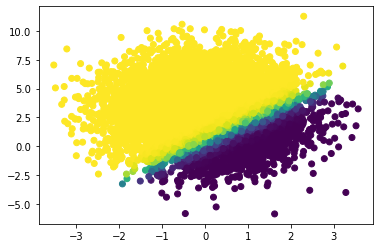

In [14]:
plt.scatter(x1, x2, c=p)

In [15]:
ntest = int(np.floor(n/10))

x1test = rng.normal(0, 1, size=ntest)
x2test = rng.normal(3, 2.2, size=ntest)

ptest = 1/(1+np.exp(-(beta0_true + beta1_true*x1test + beta2_true*x2test)))

xtest_basic = np.column_stack((x1test, x2test))

ytest_basic = rng.binomial(1, ptest, size=ntest)

In [19]:
bce_prec, bce_recall, bce_model = run_bce_model(x_basic, y_basic, xtest_basic, ytest_basic)
bce_prec, bce_recall

(0.9803012746234068, 0.986013986013986)

In [24]:
bce_prec, bce_recall, bce_model = run_bce_model_weight(x_basic, y_basic, xtest_basic, ytest_basic, weight=3)
bce_prec, bce_recall

(0.9693181818181819, 0.9941724941724942)

In [17]:
maxrecall_prec, maxrecall_recall, maxrecall_model = run_max_recall_model(
    x_basic, y_basic, xtest_basic, ytest_basic, min_prec=0.8, lam=1e4, thresh = 0.5
)
maxrecall_prec, maxrecall_recall

([[0.9737142857142858, 0.993006993006993, LogRegMaxRecall2()]],
 [[array([0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.00704225, 0.00704225, 0.01408451, 0.01408451,
          0.02112676, 0.02

### 1D dataset

In [33]:
from sklearn.datasets import make_classification

xsk, ysk = make_classification(
    n_samples=10000, 
    n_features=1, 
    n_informative=1, 
    n_redundant=0, 
    n_classes=2, 
    n_clusters_per_class=1, 
    class_sep=2.,
    random_state=6
)


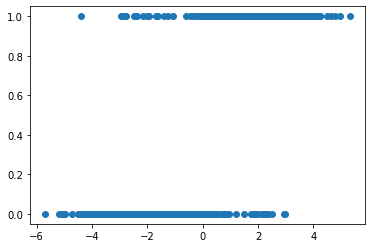

In [34]:
plt.scatter(xsk, ysk)

In [35]:
xsk_train = xsk[:9000]
ysk_train = ysk[:9000]

xsk_test = xsk[9000:]
ysk_test = ysk[9000:]

In [36]:
bce_prec, bce_recall, bce_model = run_bce_model(xsk_train, ysk_train, xsk_test, ysk_test)
bce_prec, bce_recall

(0.9842829076620825, 0.9842829076620825)

In [37]:
maxrecall_prec, maxrecall_recall, maxrecall_model = run_max_recall_model(
    xsk_train, ysk_train, xsk_test, ysk_test, min_prec=0.8, lam=1e4, thresh = 0.5
)
maxrecall_prec, maxrecall_recall

(0.972972972972973, 0.9901768172888016)

### moons dataset

In [38]:
from sklearn.datasets import make_moons

xmoons, ymoons = make_moons(n_samples = 10000, noise=0.1, random_state=7)

In [39]:
xmoons_train = xmoons[:9000]
ymoons_train = ymoons[:9000]

xmoons_test = xmoons[9000:]
ymoons_test = ymoons[9000:]

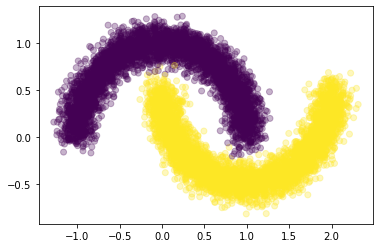

In [40]:
plt.scatter(xmoons_train[:,0], xmoons_train[:,1], c=ymoons_train, alpha=0.3)

In [41]:
bce_prec, bce_recall, bce_model = run_bce_model(xmoons_train, ymoons_train, xmoons_test, ymoons_test)
bce_prec, bce_recall

(0.8668076109936576, 0.8631578947368421)

In [44]:
maxrecall_prec, maxrecall_recall, maxrecall_model = run_max_recall_model(
    xmoons_train, ymoons_train, xmoons_test, ymoons_test, min_prec=0.9, lam=1e5, thresh = 0.5
)
maxrecall_prec, maxrecall_recall

(0.9547872340425532, 0.7557894736842106)

### dtatset from papaer

In [162]:
#https://github.com/tufts-ml/false-alarm-control/blob/main/toy_example_comparing_BCE_Hinge_and_Sigmoid.ipynb

from false_alarm_control import toydata

In [163]:
x_toy, y_toy, _, _, _, _ = toydata.create_toy_dataset()

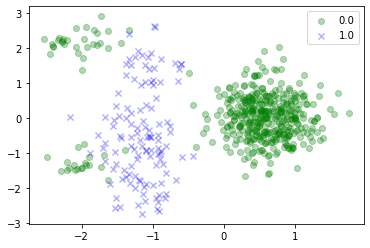

In [168]:
cdict = {0: 'green', 1: 'blue'}
mdict = {0:'o', 1:'x'}

fig, ax = plt.subplots()
for g in np.unique(y_toy):
    ix = np.where(y_toy == g)
    ax.scatter(x_toy[ix,0], x_toy[ix,1], c = cdict[g], marker=mdict[g], label = g, alpha=0.3)
ax.legend()

plt.show()

In [184]:
idx = np.array(range(y_toy.shape[0]))

rng.shuffle(idx)

In [185]:
xtrain_toy = x_toy[idx[:300]]
ytrain_toy = y_toy[idx[:300]]

xtest_toy = x_toy[idx[300:]]
ytest_toy = y_toy[idx[300:]]

In [186]:
bce_prec, bce_recall, bce_model = run_bce_model(xtrain_toy, ytrain_toy, xtest_toy, ytest_toy)
bce_prec, bce_recall

(0.7368421052631579, 0.509090909090909)

0.7


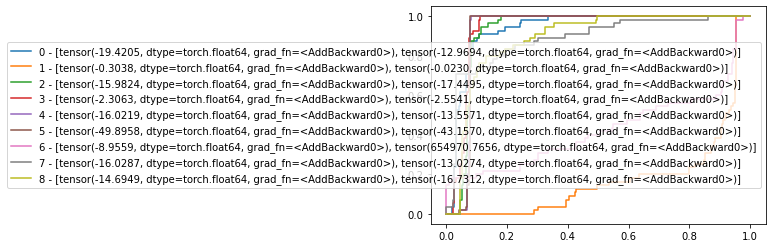

0.75


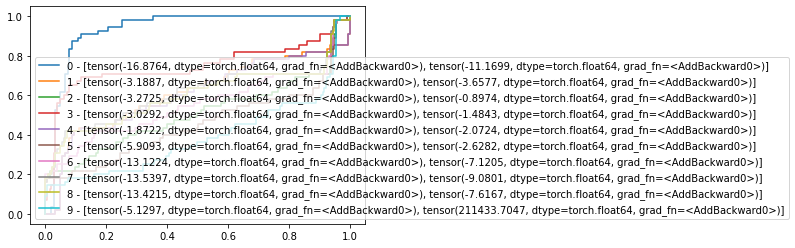

0.8


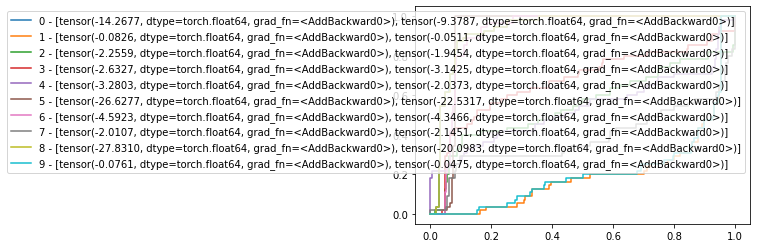

0.8500000000000001


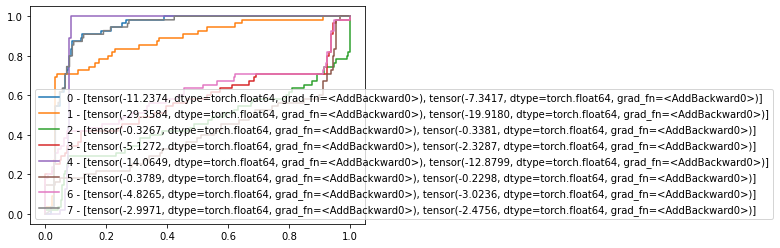

0.9000000000000001


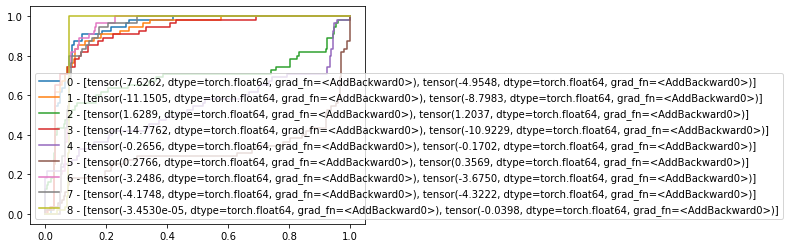

In [270]:
for prec in np.arange(0.7,0.9,0.05):
    outputs = run_max_recall_model(
        xtrain_toy, ytrain_toy, xtest_toy, ytest_toy, min_prec=prec, lam=1e5, thresh = 0.5, num_random_initial_params=10
    )
    print(prec)
    roc_curve_vals = outputs[1]
    loss = outputs[2]

    for i, curve_vals in enumerate(roc_curve_vals):
        plt.plot(curve_vals[0], curve_vals[1], label=f"{i} - {loss[i]}")
    plt.legend()
    plt.show()
    

In [192]:
for prec in np.arange(0.7,0.9,0.05):
    outputs = run_max_recall_model(
        xtrain_toy, ytrain_toy, xtest_toy, ytest_toy, min_prec=prec, lam=1e4, thresh = 0.5, num_random_initial_params=100
    )
    print(prec)
    print(outputs)
    

Parameter containing:
tensor([-1.5028, -0.6859, -2.0375], requires_grad=True)
0.7
([0.8333333333333334, 0.6363636363636364, LogRegMaxRecall2()], [[0.7, 0.7636363636363637, LogRegMaxRecall2()], [0.7258064516129032, 0.8181818181818182, LogRegMaxRecall2()], [0.7272727272727273, 0.43636363636363634, LogRegMaxRecall2()], [0.75, 0.9818181818181818, LogRegMaxRecall2()], [0.7536231884057971, 0.9454545454545454, LogRegMaxRecall2()], [0.7536231884057971, 0.9454545454545454, LogRegMaxRecall2()], [0.7536231884057971, 0.9454545454545454, LogRegMaxRecall2()], [0.9, 0.16363636363636364, LogRegMaxRecall2()], [0.9, 0.16363636363636364, LogRegMaxRecall2()], [1.0, 0.01818181818181818, LogRegMaxRecall2()], [1.0, 0.09090909090909091, LogRegMaxRecall2()], [1.0, 0.18181818181818182, LogRegMaxRecall2()], [1.0, 0.16363636363636364, LogRegMaxRecall2()], [1.0, 0.09090909090909091, LogRegMaxRecall2()], [1.0, 0.07272727272727272, LogRegMaxRecall2()]])
Parameter containing:
tensor([-1.5028, -0.6859, -2.0375], requi

### diabites data

In [193]:
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

In [194]:
data_df = pd.read_csv('data/diabetes2.csv')

df_train, df_test = train_test_split(data_df, test_size=0.3)

X_train = df_train.drop(columns='Outcome').values
y_train = df_train['Outcome'].values

X_test = df_test.drop(columns='Outcome').values
y_test = df_test['Outcome'].values

In [195]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [203]:
x_train_scaled = scaler.transform(X_train)
x_test_scaled = scaler.transform(X_test)

In [204]:
bce_prec, bce_recall, bce_model = run_bce_model(x_train_scaled, y_train, x_test_scaled, y_test)
bce_prec, bce_recall

(0.6140350877192983, 0.4605263157894737)

In [214]:
for prec in np.arange(0.7,0.9,0.05):
    outputs = run_max_recall_model(
        xtrain_toy, ytrain_toy, xtest_toy, ytest_toy, min_prec=prec, lam=1e4, thresh = 0.5, num_random_initial_params=100
    )
    print(prec)
    print(outputs)
    

0.7
([0.8333333333333334, 0.6363636363636364, LogRegMaxRecall2()], [[0.8205128205128205, 0.5818181818181818, LogRegMaxRecall2()], [0.8333333333333334, 0.6363636363636364, LogRegMaxRecall2()], [0.8409090909090909, 0.6727272727272727, LogRegMaxRecall2()], [0.8444444444444444, 0.6909090909090909, LogRegMaxRecall2()], [0.9090909090909091, 0.18181818181818182, LogRegMaxRecall2()], [1.0, 0.16363636363636364, LogRegMaxRecall2()], [1.0, 0.09090909090909091, LogRegMaxRecall2()], [1.0, 0.10909090909090909, LogRegMaxRecall2()], [1.0, 0.10909090909090909, LogRegMaxRecall2()], [1.0, 0.07272727272727272, LogRegMaxRecall2()], [1.0, 0.10909090909090909, LogRegMaxRecall2()], [1.0, 0.07272727272727272, LogRegMaxRecall2()], [1.0, 0.16363636363636364, LogRegMaxRecall2()], [1.0, 0.10909090909090909, LogRegMaxRecall2()], [1.0, 0.10909090909090909, LogRegMaxRecall2()]])
0.75
([0.825, 0.6, LogRegMaxRecall2()], [[1.0, 0.14545454545454545, LogRegMaxRecall2()], [1.0, 0.16363636363636364, LogRegMaxRecall2()], [1.

In [205]:
for prec in np.arange(0.7,0.9,0.05):
    outputs = run_max_recall_model(
        xtrain_toy, ytrain_toy, xtest_toy, ytest_toy, min_prec=prec, lam=1e4, thresh = 0.5, num_random_initial_params=100
    )
    print(prec)
    print(outputs)

0.7
([0.8333333333333334, 0.6363636363636364, LogRegMaxRecall2()], [[0.7638888888888888, 1.0, LogRegMaxRecall2()], [0.7638888888888888, 1.0, LogRegMaxRecall2()], [0.7638888888888888, 1.0, LogRegMaxRecall2()], [0.7638888888888888, 1.0, LogRegMaxRecall2()], [0.7638888888888888, 1.0, LogRegMaxRecall2()], [0.7638888888888888, 1.0, LogRegMaxRecall2()], [0.7638888888888888, 1.0, LogRegMaxRecall2()], [0.7638888888888888, 1.0, LogRegMaxRecall2()], [0.7638888888888888, 1.0, LogRegMaxRecall2()], [0.825, 0.6, LogRegMaxRecall2()], [0.825, 0.6, LogRegMaxRecall2()], [0.8333333333333334, 0.6363636363636364, LogRegMaxRecall2()], [0.8333333333333334, 0.6363636363636364, LogRegMaxRecall2()], [0.8409090909090909, 0.6727272727272727, LogRegMaxRecall2()], [1.0, 0.16363636363636364, LogRegMaxRecall2()]])
0.75
([0.825, 0.6, LogRegMaxRecall2()], [[0.8333333333333334, 0.6363636363636364, LogRegMaxRecall2()], [0.8333333333333334, 0.6363636363636364, LogRegMaxRecall2()], [0.8333333333333334, 0.6363636363636364, 